In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'BAYN.DE'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-12-31,10792,-5325,5467,218,1853,9097,8478,22227,15347,...,5363,0,3376,15503,18484,50128,2230,-939,826.95,2015-03-01
1,2015-03-31,11793,-5436,6357,1282,1607,11466,8776,24951,16405,...,5211,0,6512,20263,16921,54905,727,-345,826.95,2015-05-10
2,2015-06-30,12003,-5267,6736,1146,3247,11242,8668,26158,15980,...,5239,0,7676,20751,17178,53323,1959,-601,826.95,2015-08-09
3,2015-09-30,11004,-4940,6064,994,2395,9995,8711,24997,15932,...,5129,0,6036,19342,16740,51988,2332,-655,826.95,2015-11-09
4,2015-12-31,11285,-5397,5888,591,1859,9933,8550,23821,16096,...,5945,0,3421,16980,16513,49652,1877,-916,826.95,2016-02-29


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2023-09-30,2023-11-09,982.42,10342,-4812,5530,-4577,6815,10532,13956,...,23169,117242,6500,0,12313,33081,35111,83862,2576,-683
36,2023-12-31,2024-02-29,982.42,11862,-4486,7376,1342,5907,9343,13947,...,23363,116259,7456,0,6830,29457,38176,83332,5608,-996
37,2024-03-31,2024-05-13,982.42,13765,-5463,8302,2002,4725,14194,13437,...,23343,119881,6398,0,8281,30630,37987,84119,-2150,-446
38,2024-06-30,2024-08-05,982.42,11144,-4994,6150,-26,3888,13442,13088,...,22985,119859,6127,0,9181,31561,37397,84012,2410,-628
39,2024-09-30,2024-11-11,982.42,9968,-5090,4878,-4194,4619,10307,12945,...,21608,106946,6561,0,4490,25048,36672,76252,2111,-605


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-09-30,2023-11-09,982.42,10342,-4812,5530,-4577,6815,10532,13956,...,117242,6500,0,12313,33081,35111,83862,2576,-683,0.918837
36,2023-12-31,2024-02-29,982.42,11862,-4486,7376,1342,5907,9343,13947,...,116259,7456,0,6830,29457,38176,83332,5608,-996,0.929674
37,2024-03-31,2024-05-13,982.42,13765,-5463,8302,2002,4725,14194,13437,...,119881,6398,0,8281,30630,37987,84119,-2150,-446,0.920544
38,2024-06-30,2024-08-05,982.42,11144,-4994,6150,-26,3888,13442,13088,...,119859,6127,0,9181,31561,37397,84012,2410,-628,0.928647
39,2024-09-30,2024-11-11,982.42,9968,-5090,4878,-4194,4619,10307,12945,...,106946,6561,0,4490,25048,36672,76252,2111,-605,0.910617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-09-30,2023-11-09,982.42,10342,-4812,5530,-4577,6815,10532,13956,...,117242,6500,0,12313,33081,35111,83862,2576,-683,0.918837
36,2023-12-31,2024-02-29,982.42,11862,-4486,7376,1342,5907,9343,13947,...,116259,7456,0,6830,29457,38176,83332,5608,-996,0.929674
37,2024-03-31,2024-05-13,982.42,13765,-5463,8302,2002,4725,14194,13437,...,119881,6398,0,8281,30630,37987,84119,-2150,-446,0.920544
38,2024-06-30,2024-08-05,982.42,11144,-4994,6150,-26,3888,13442,13088,...,119859,6127,0,9181,31561,37397,84012,2410,-628,0.928647
39,2024-09-30,2024-11-11,982.42,9968,-5090,4878,-4194,4619,10307,12945,...,106946,6561,0,4490,25048,36672,76252,2111,-605,0.910617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2015-03-02,97.409691,2014-12-31,10792.0,0.0,24.313441,826.95,0.0,0.0,1853.0,...,0.286272,0.713728,0.0,0.0,0.0,0.0,0.506579,0.0202,0.0,0.0
1,2015-03-09,103.276863,2014-12-31,10792.0,0.0,24.313441,826.95,0.0,0.0,1853.0,...,0.286272,0.713728,0.0,0.0,0.0,0.0,0.506579,0.0202,0.0,0.0
2,2015-03-16,104.916740,2014-12-31,10792.0,0.0,24.313441,826.95,0.0,0.0,1853.0,...,0.286272,0.713728,0.0,0.0,0.0,0.0,0.506579,0.0202,0.0,0.0
3,2015-03-23,101.418320,2014-12-31,10792.0,0.0,24.313441,826.95,0.0,0.0,1853.0,...,0.286272,0.713728,0.0,0.0,0.0,0.0,0.506579,0.0202,0.0,0.0
4,2015-03-30,101.163216,2014-12-31,10792.0,0.0,24.313441,826.95,0.0,0.0,1853.0,...,0.286272,0.713728,0.0,0.0,0.0,0.0,0.506579,0.0202,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2015-03-02,97.409691,2014-12-31,10792.0,0.0,24.313441,826.95,0.0,0.0,1853.0,...,0.0,0.506579,0.0202,0.0,0.0,inf,4.006413,inf,inf,inf
1,2015-03-09,103.276863,2014-12-31,10792.0,0.0,24.313441,826.95,0.0,0.0,1853.0,...,0.0,0.506579,0.0202,0.0,0.0,inf,4.247727,inf,inf,inf
2,2015-03-16,104.916740,2014-12-31,10792.0,0.0,24.313441,826.95,0.0,0.0,1853.0,...,0.0,0.506579,0.0202,0.0,0.0,inf,4.315174,inf,inf,inf
3,2015-03-23,101.418320,2014-12-31,10792.0,0.0,24.313441,826.95,0.0,0.0,1853.0,...,0.0,0.506579,0.0202,0.0,0.0,inf,4.171286,inf,inf,inf
4,2015-03-30,101.163216,2014-12-31,10792.0,0.0,24.313441,826.95,0.0,0.0,1853.0,...,0.0,0.506579,0.0202,0.0,0.0,inf,4.160794,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

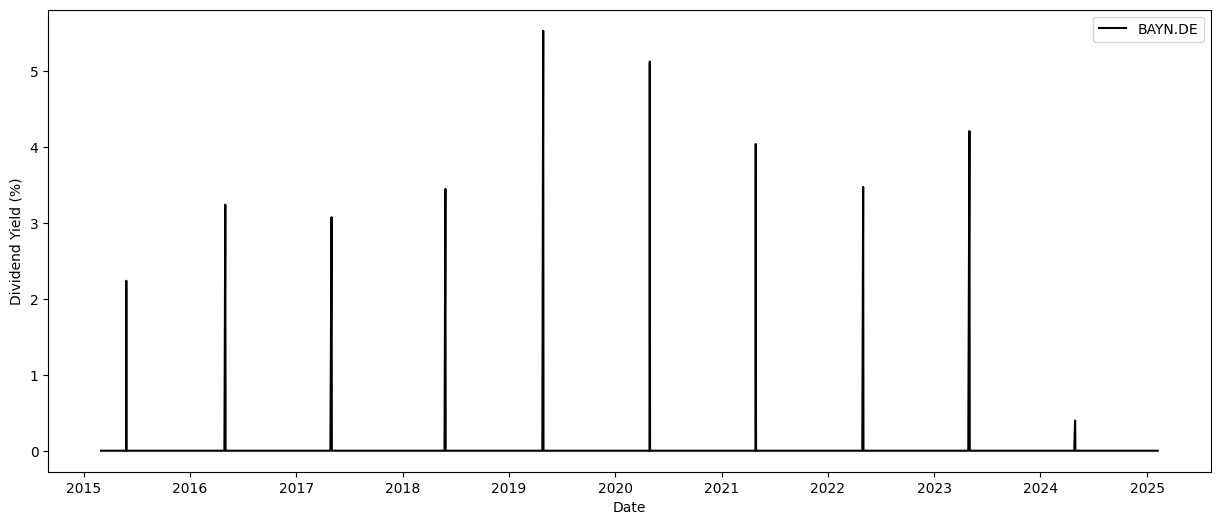

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.179744
share_price      1.000000
Name: share_price, dtype: float64


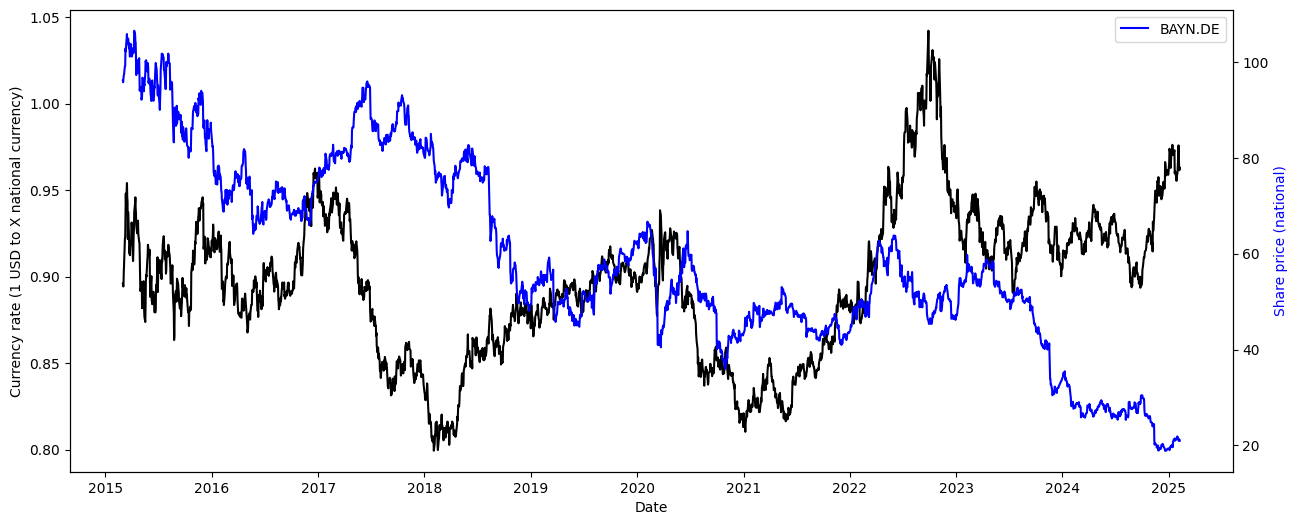

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

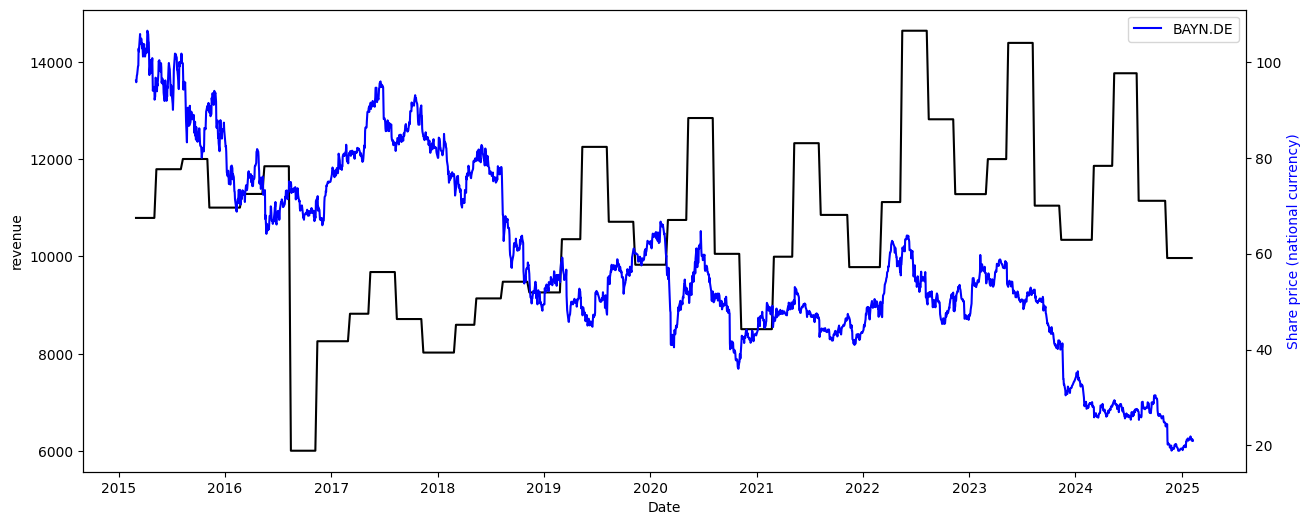

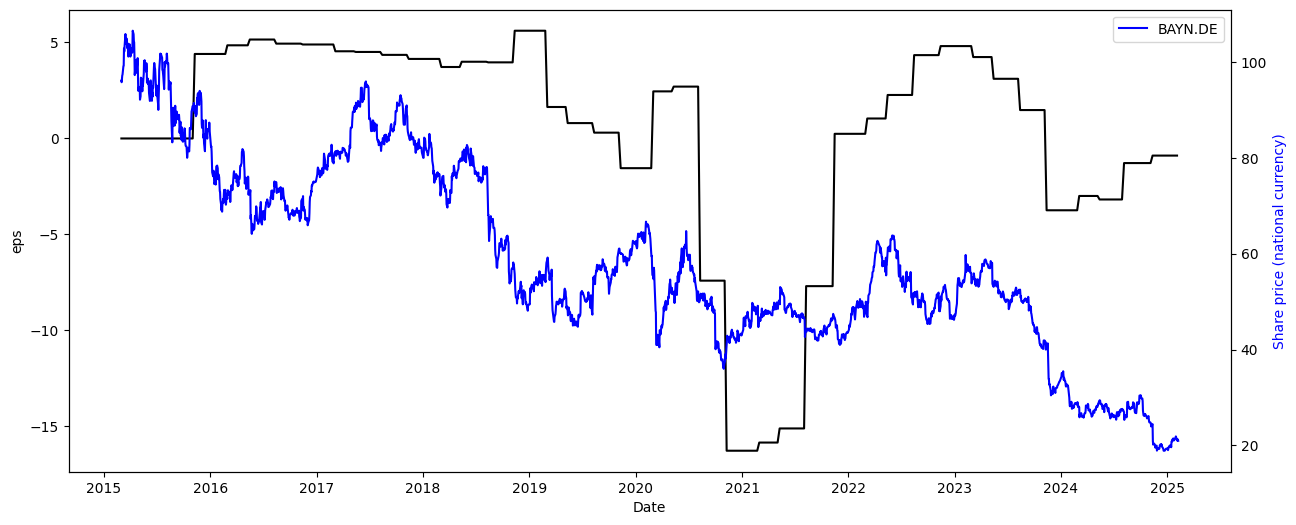

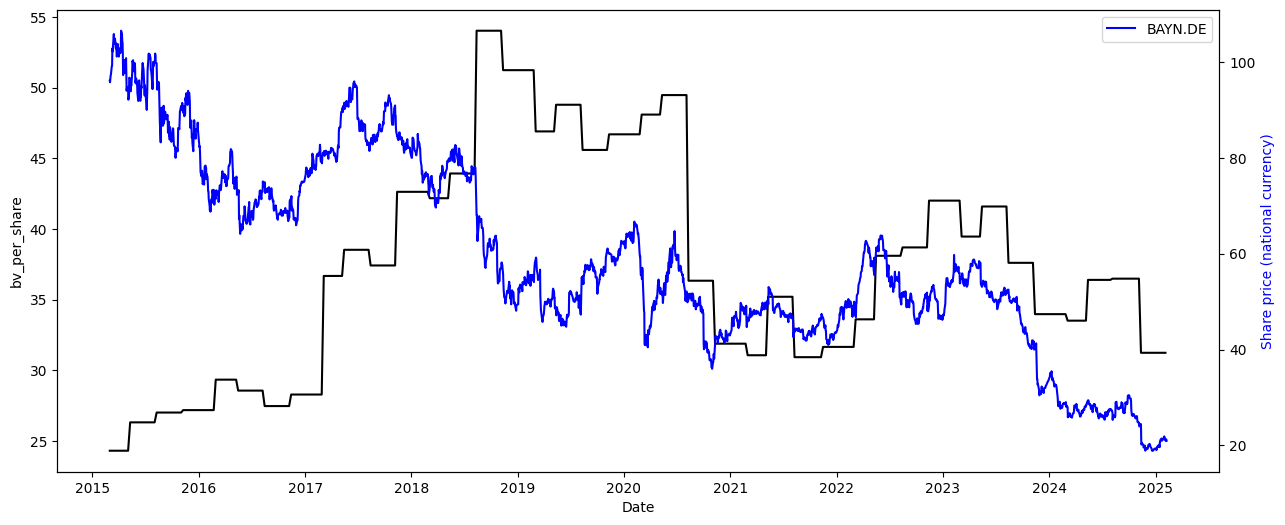

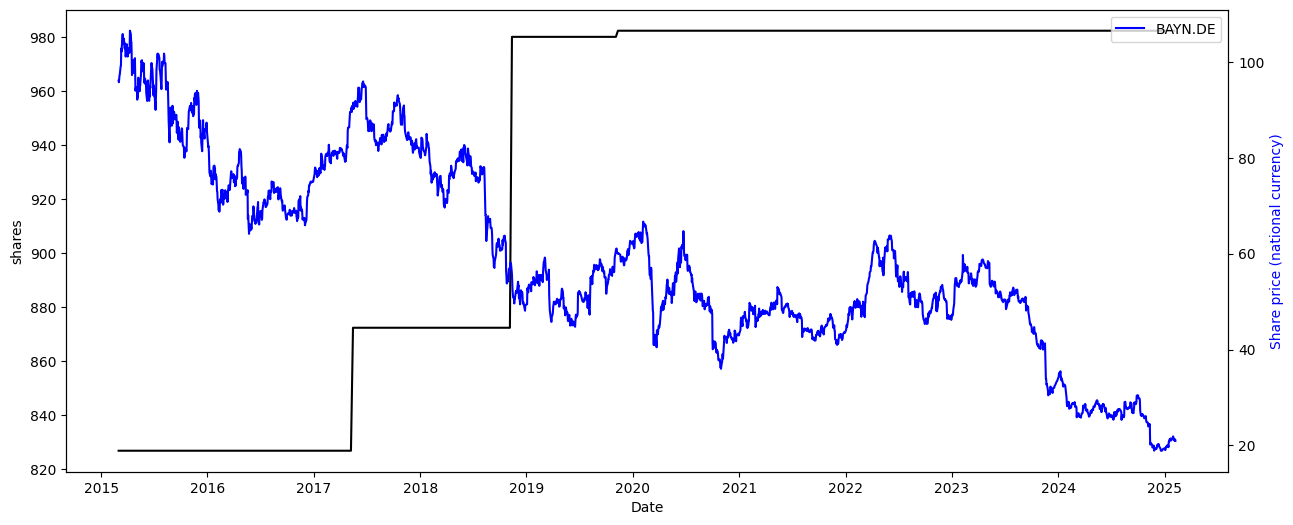

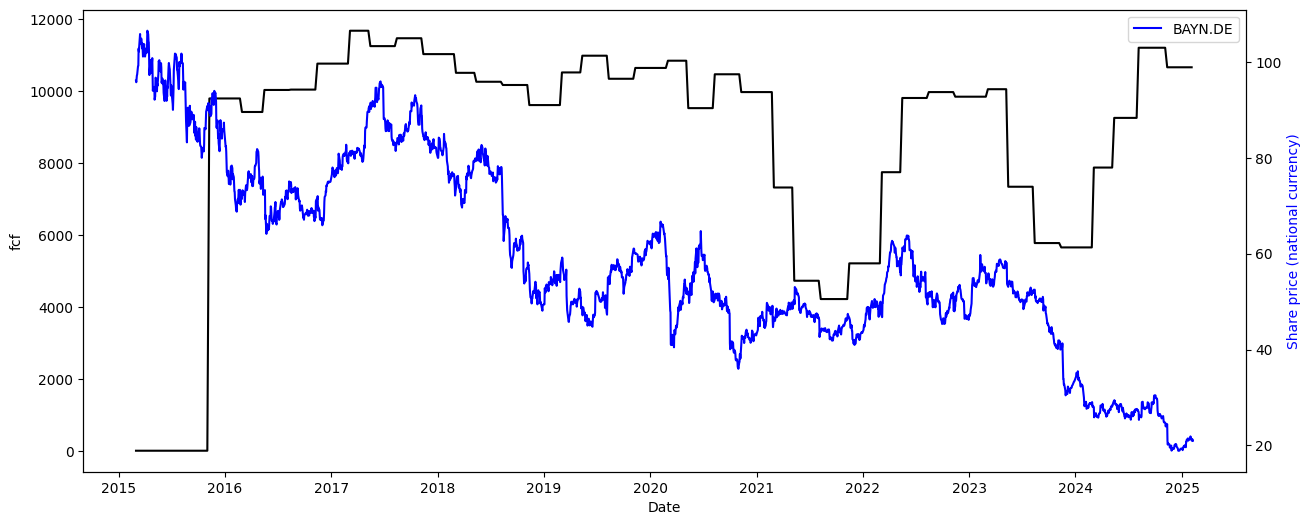

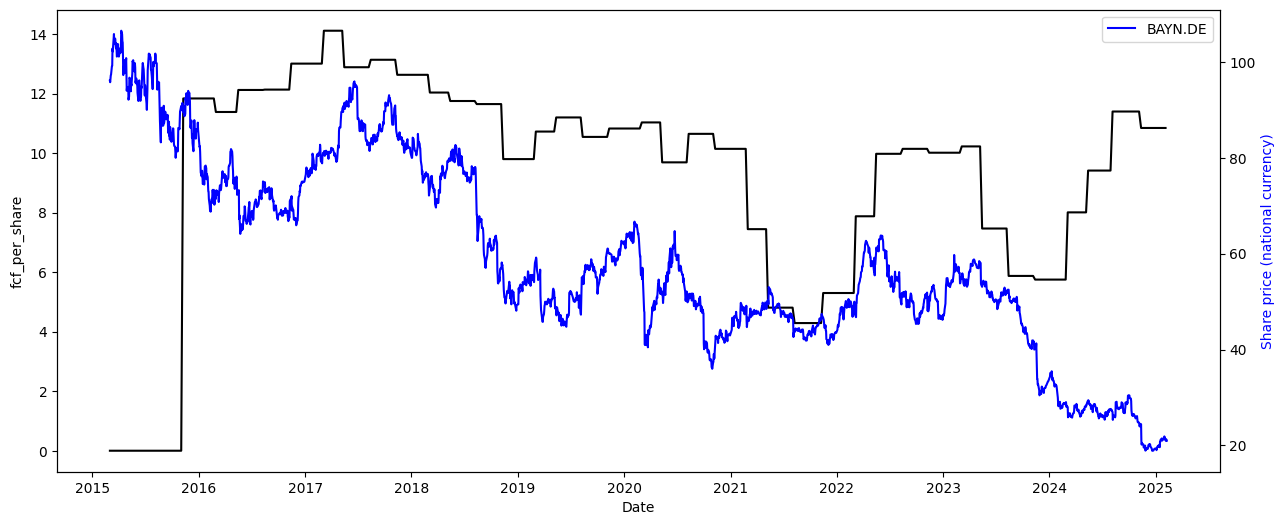

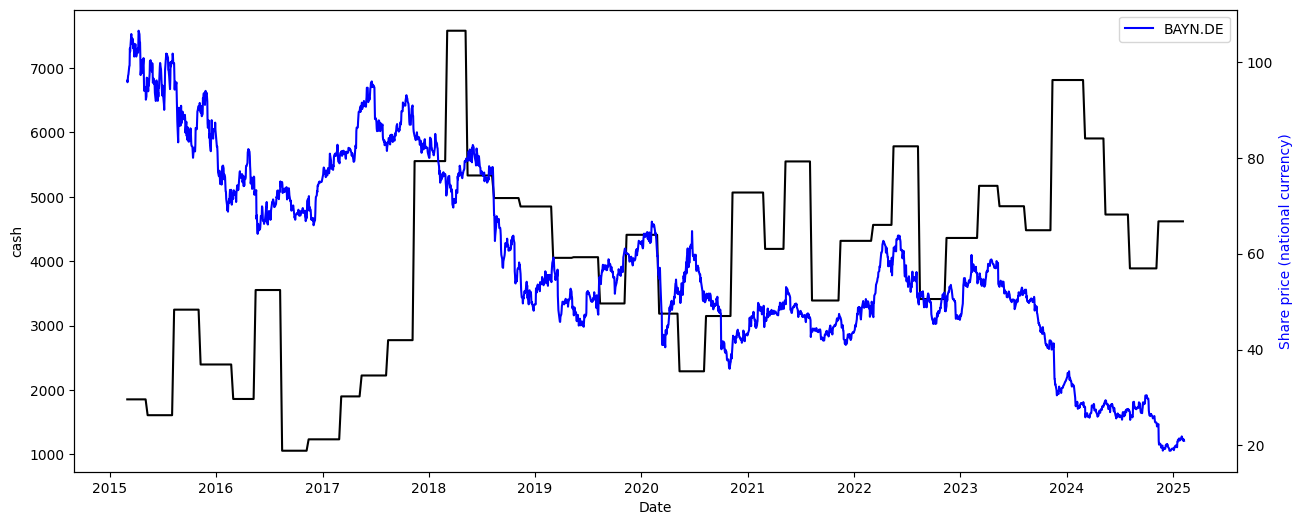

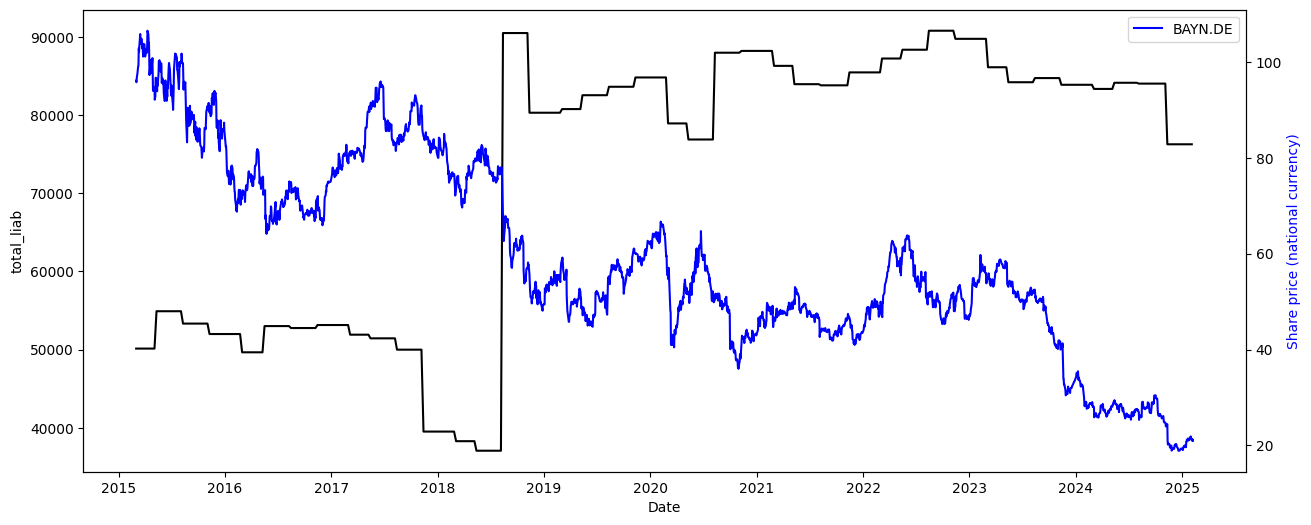

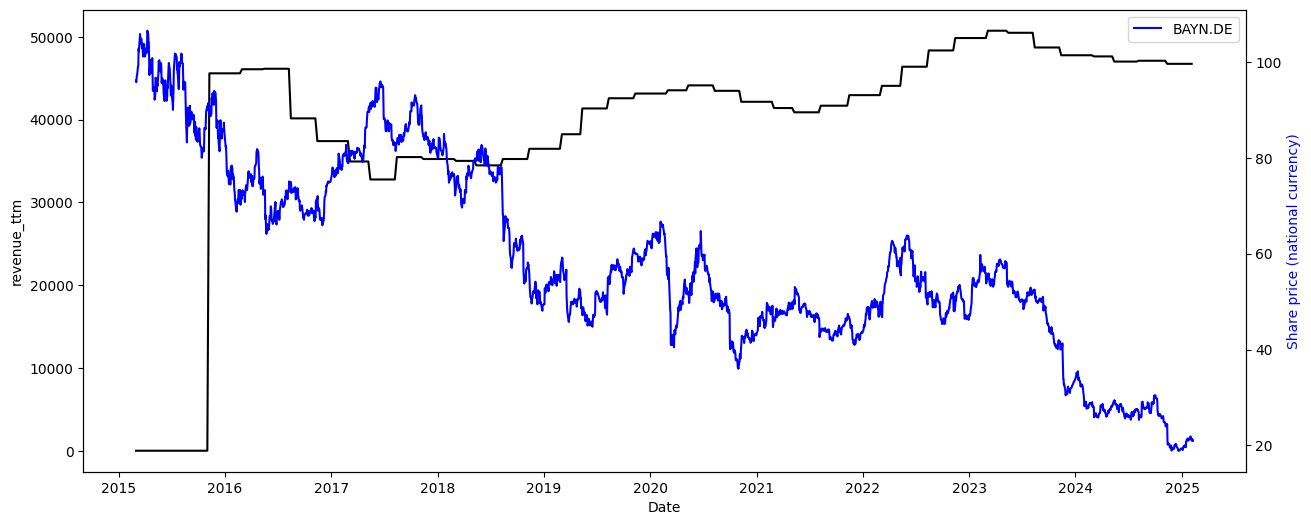

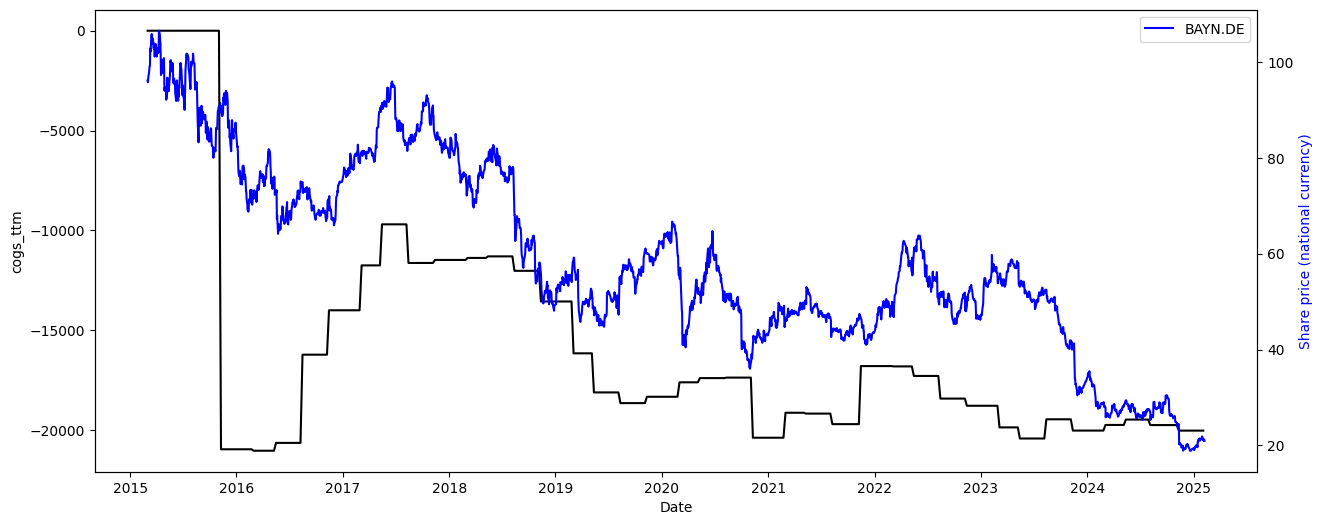

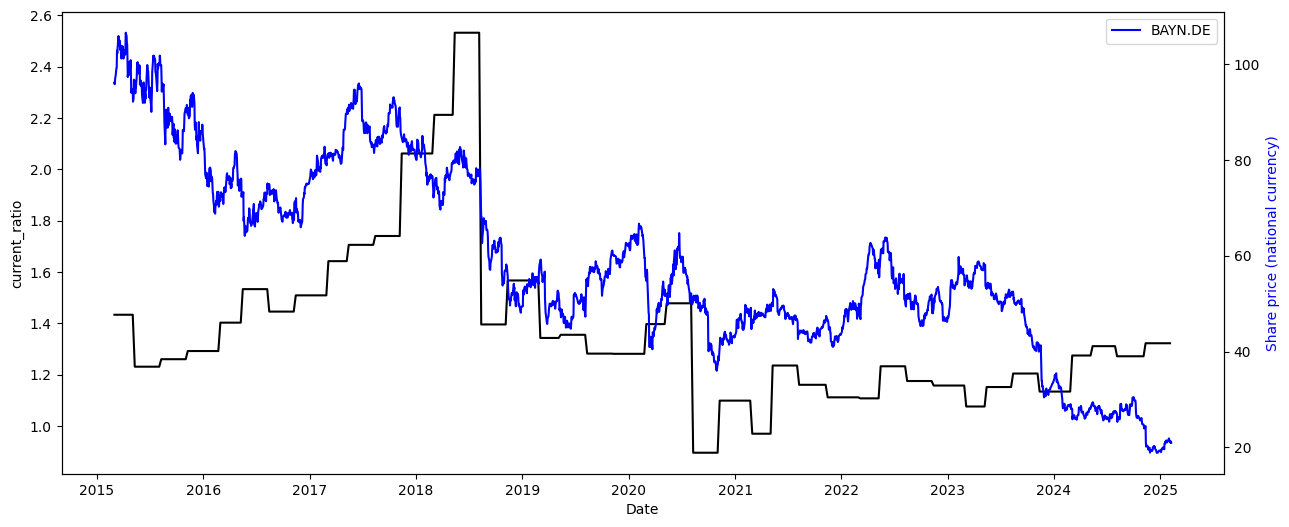

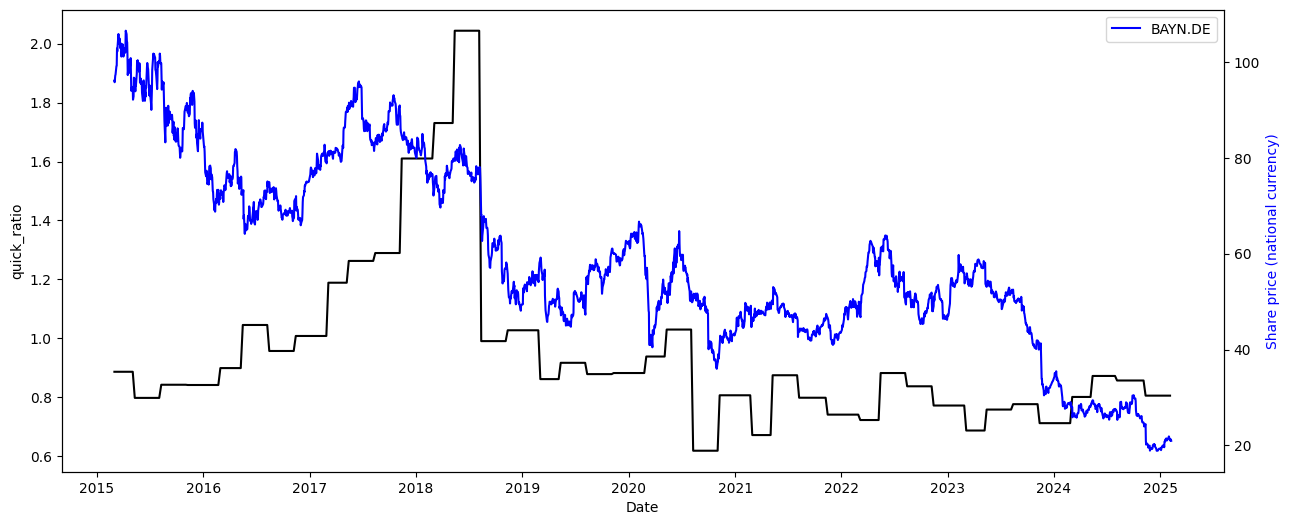

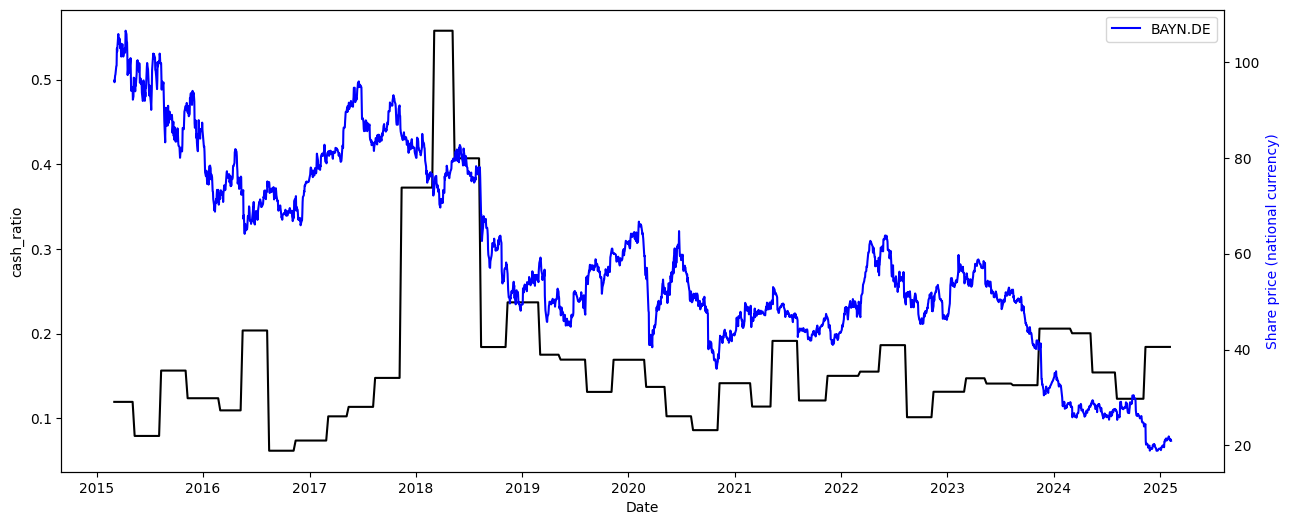

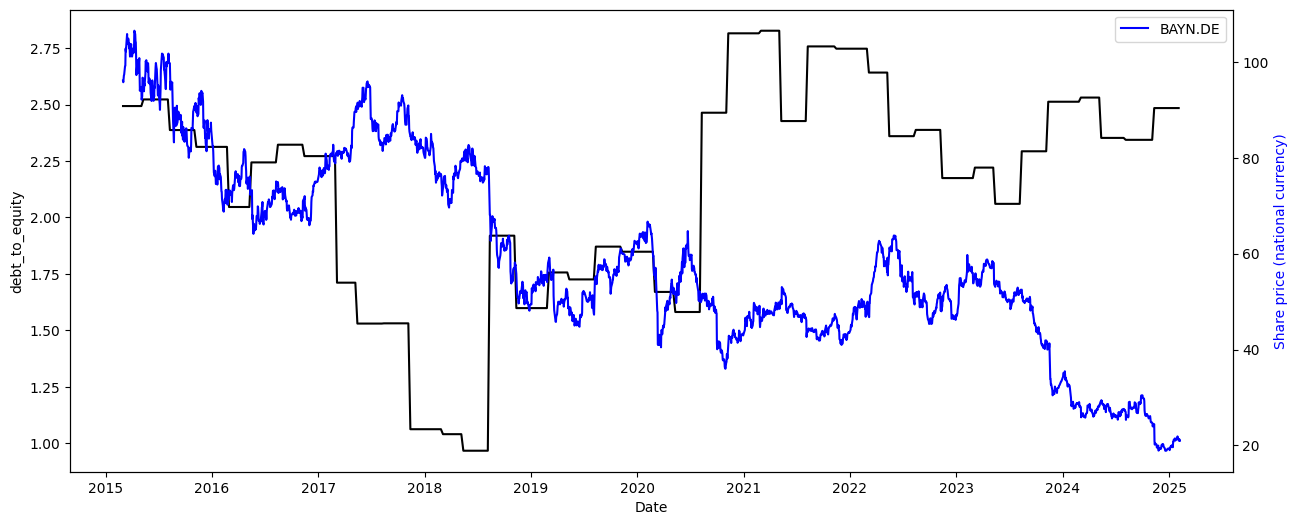

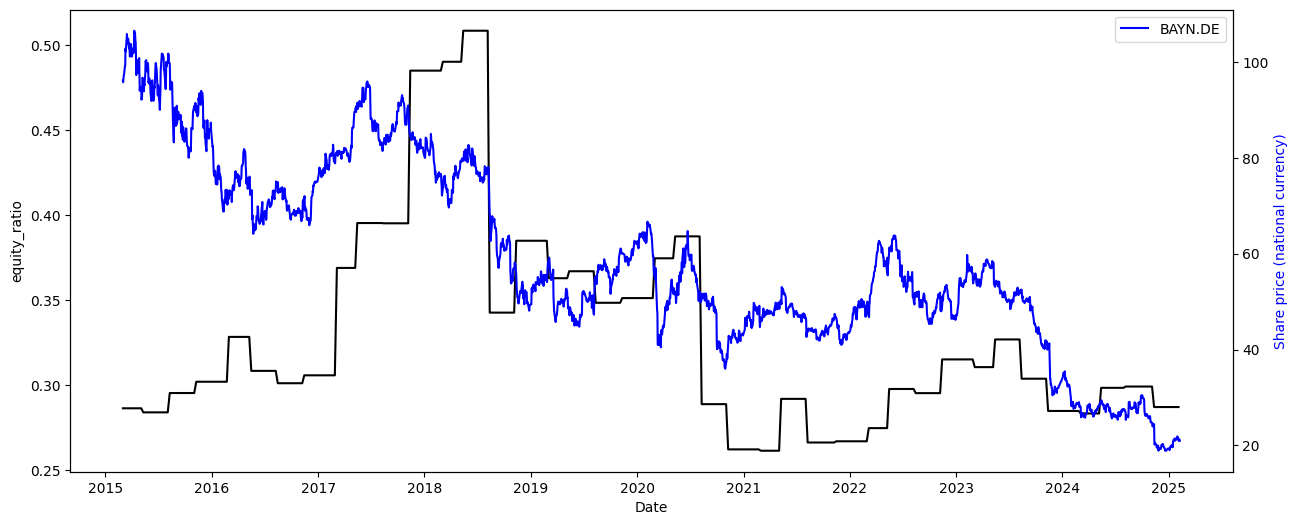

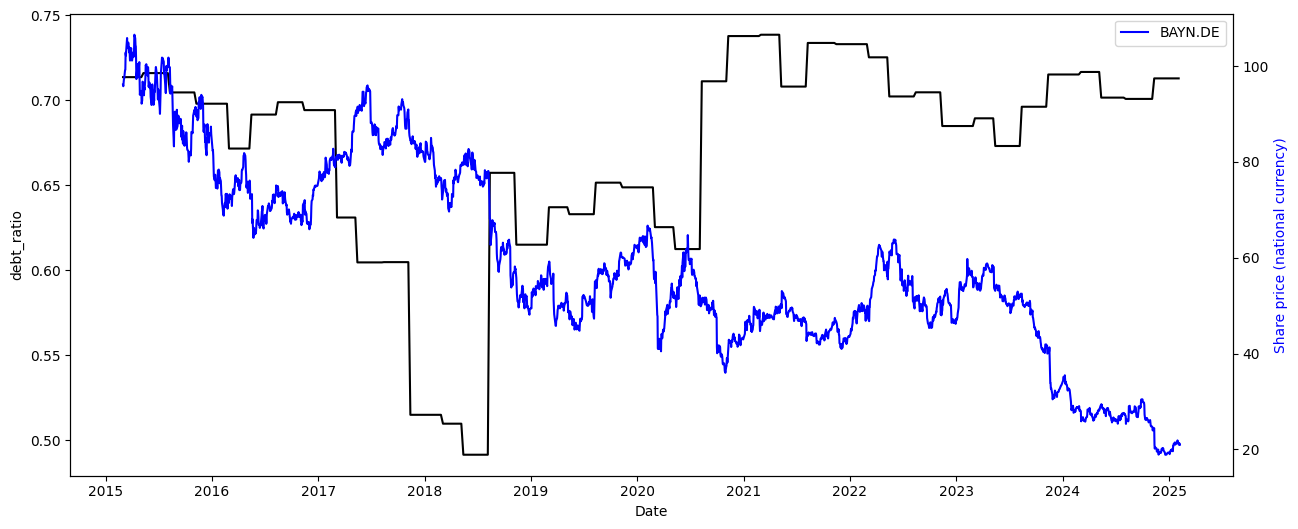

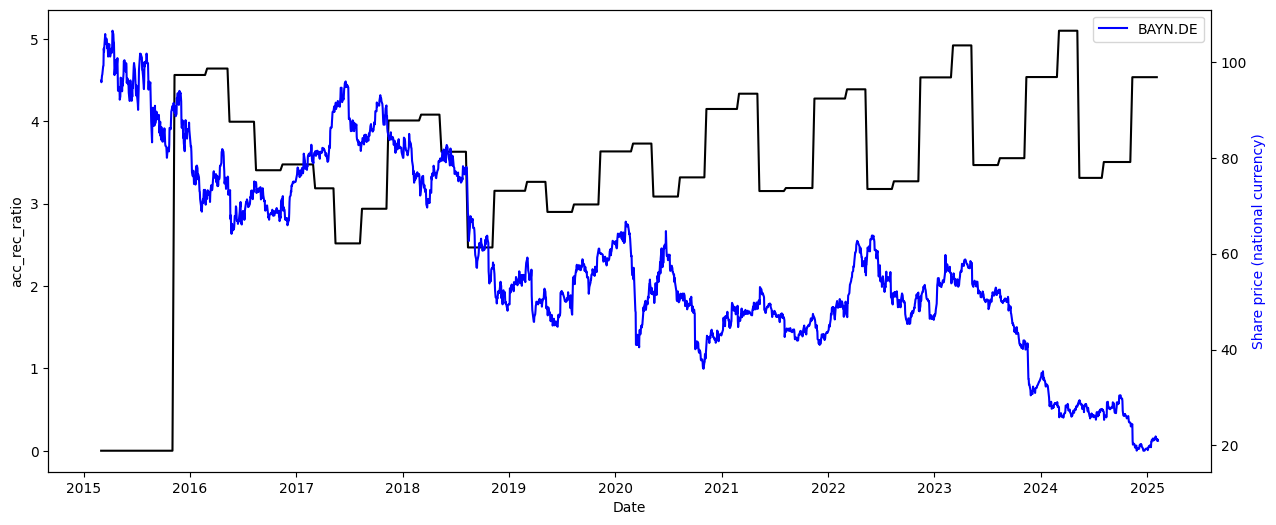

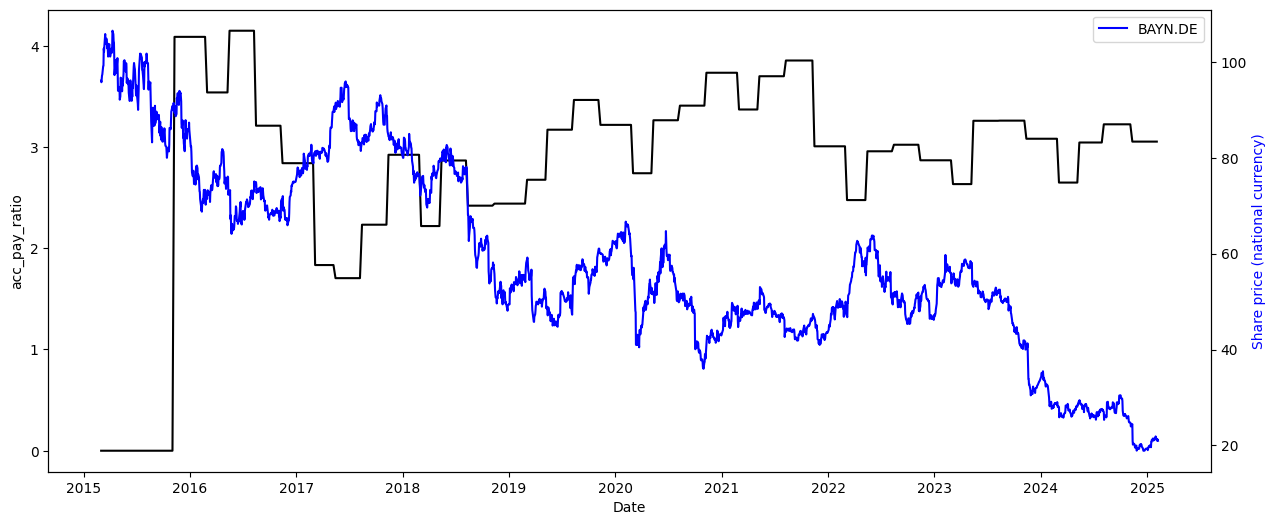

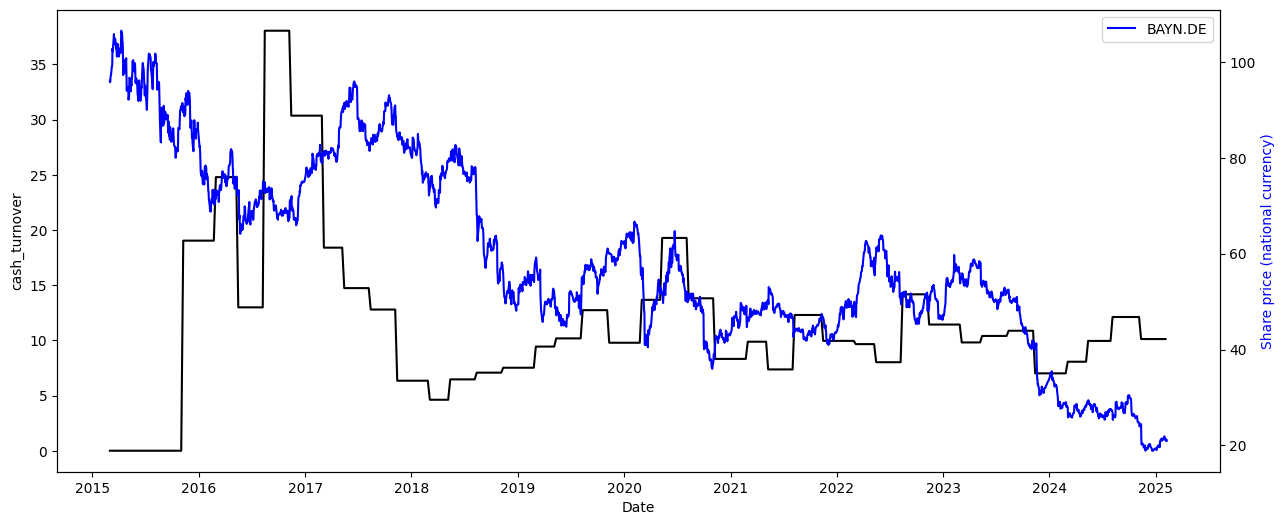

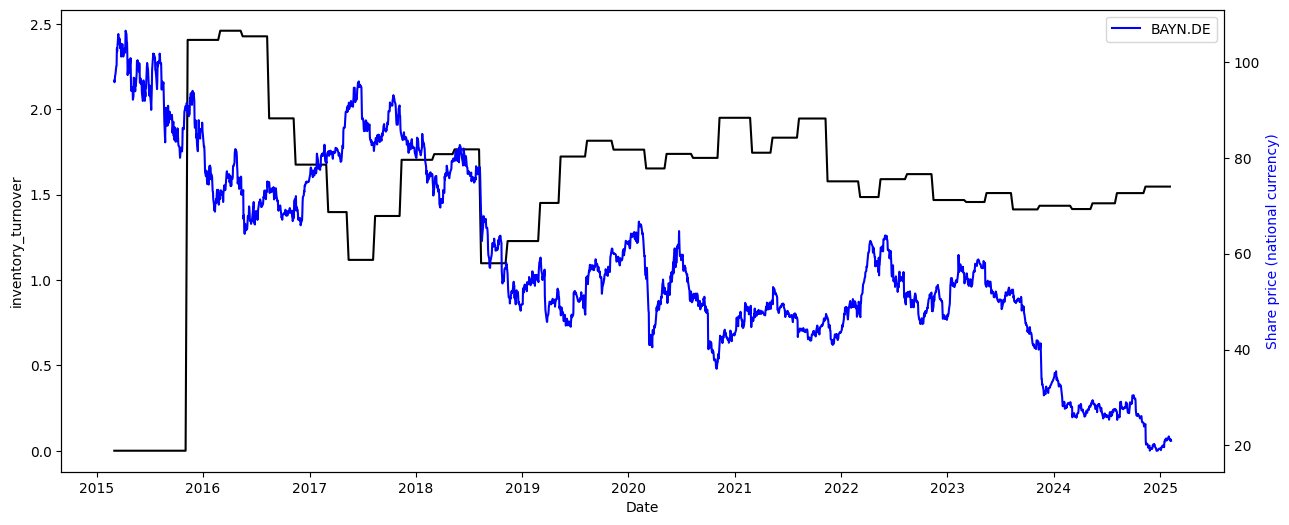

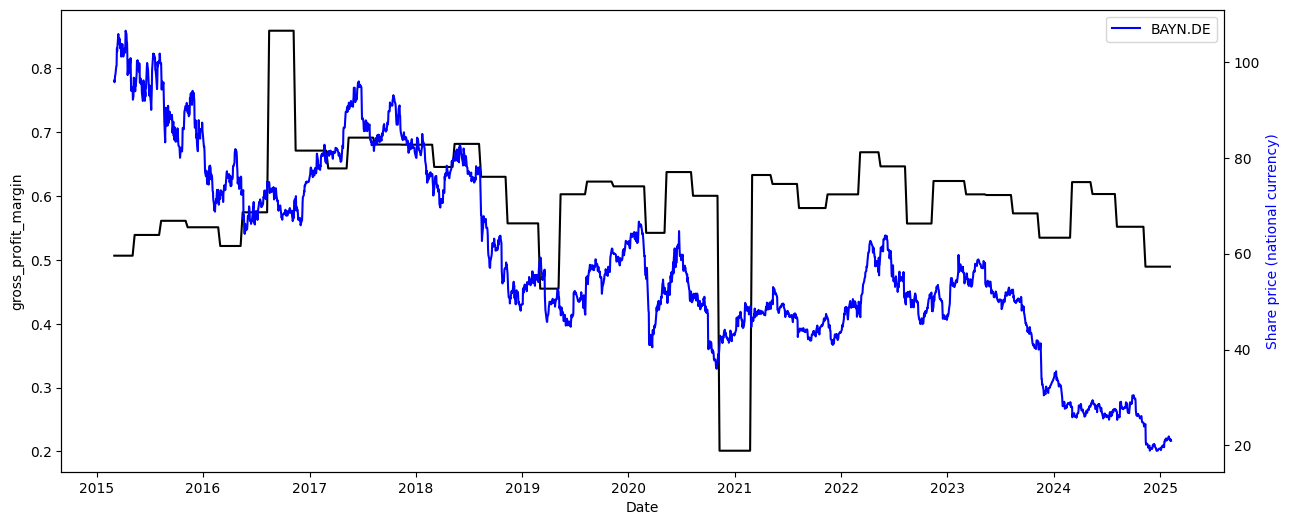

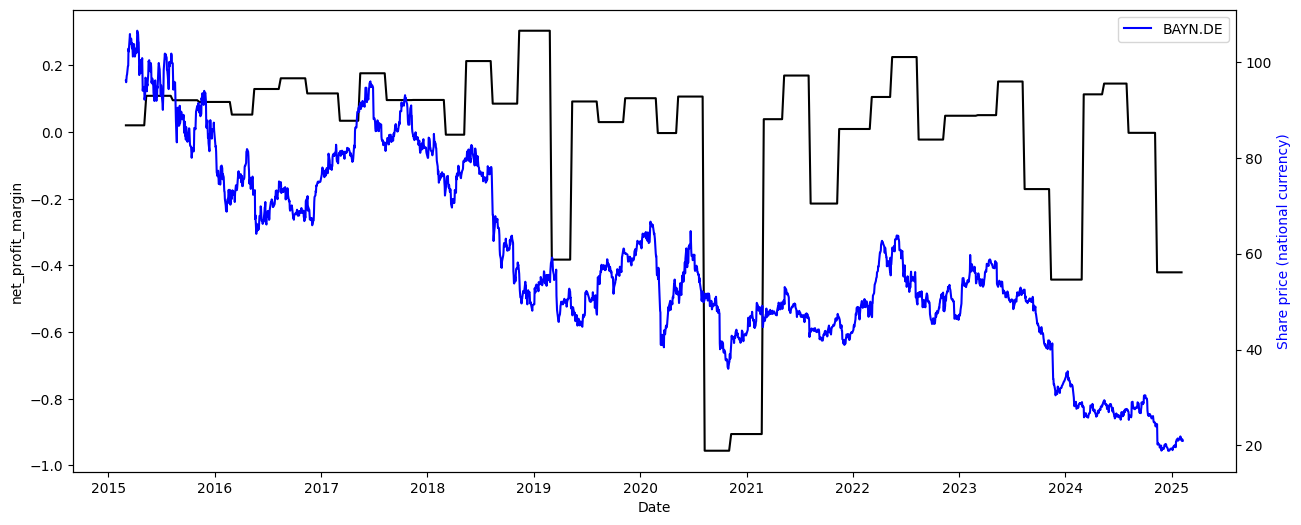

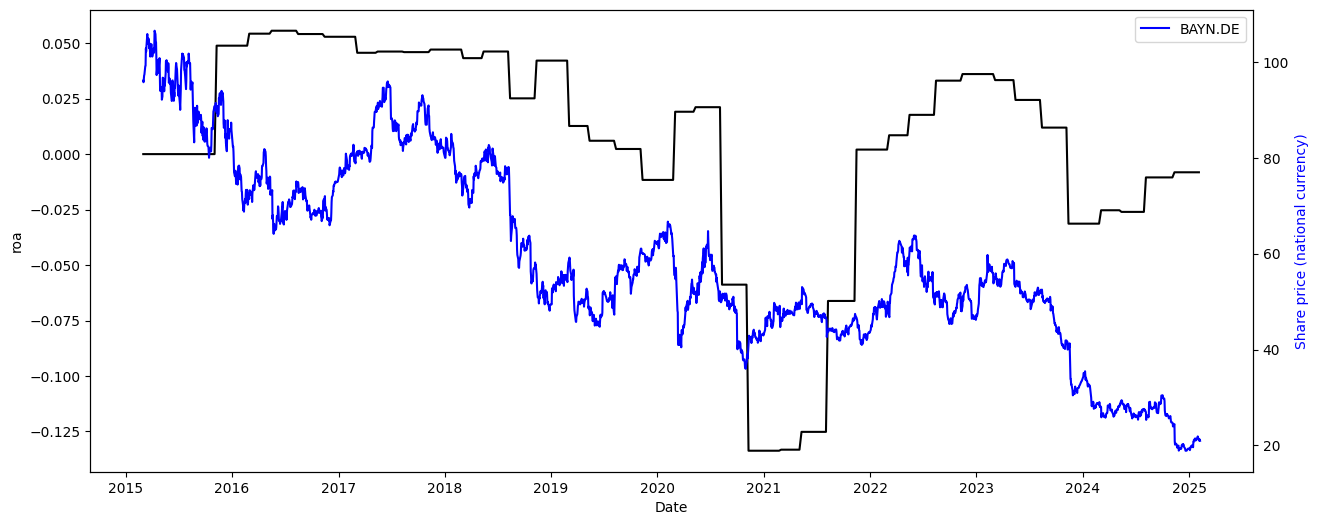

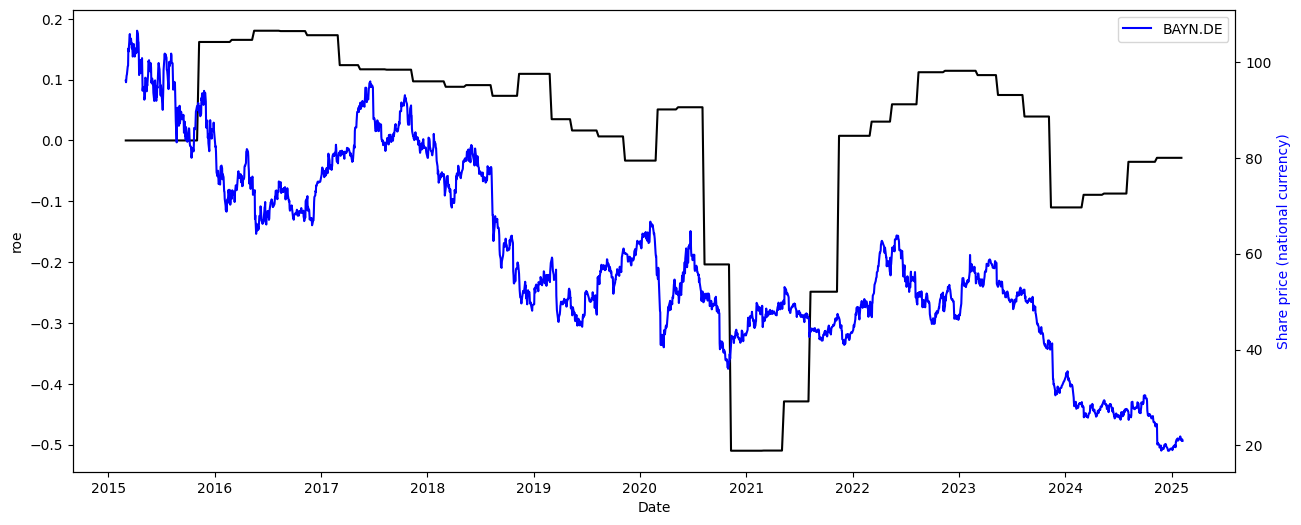

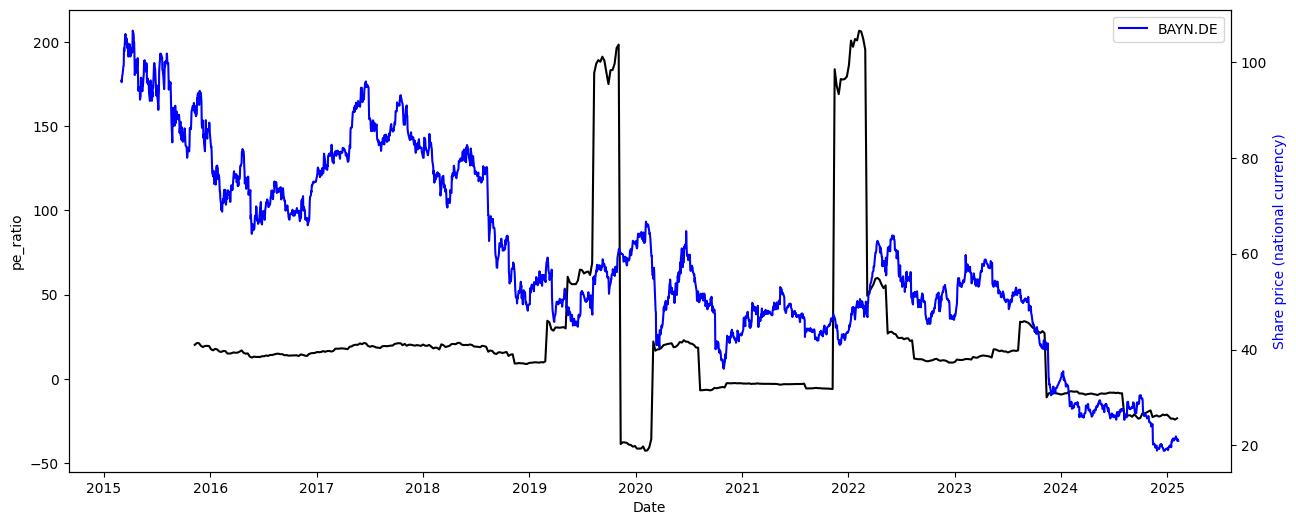

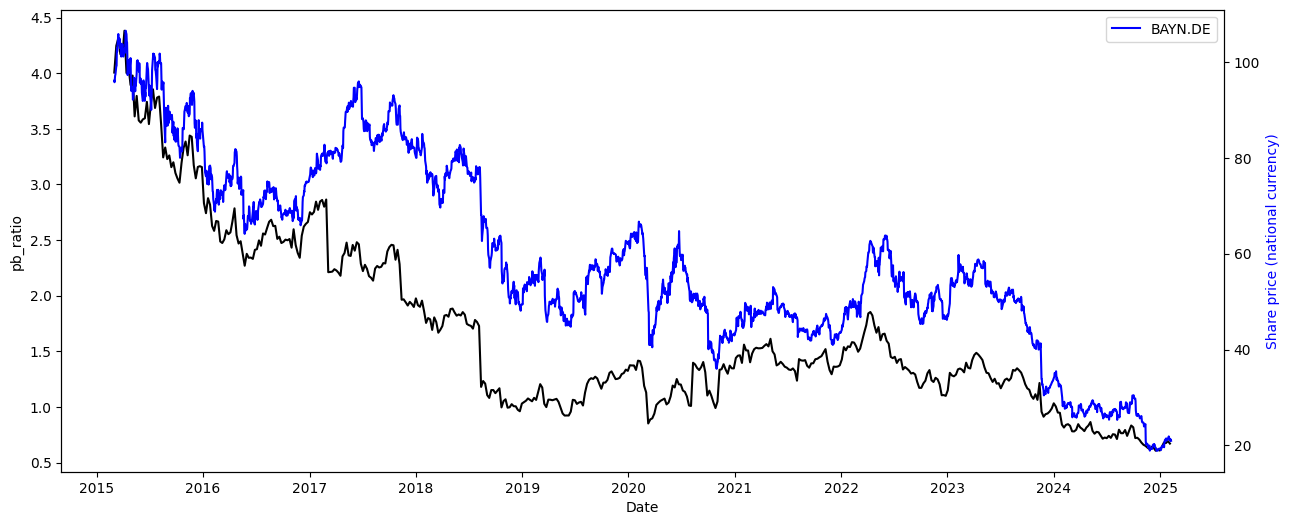

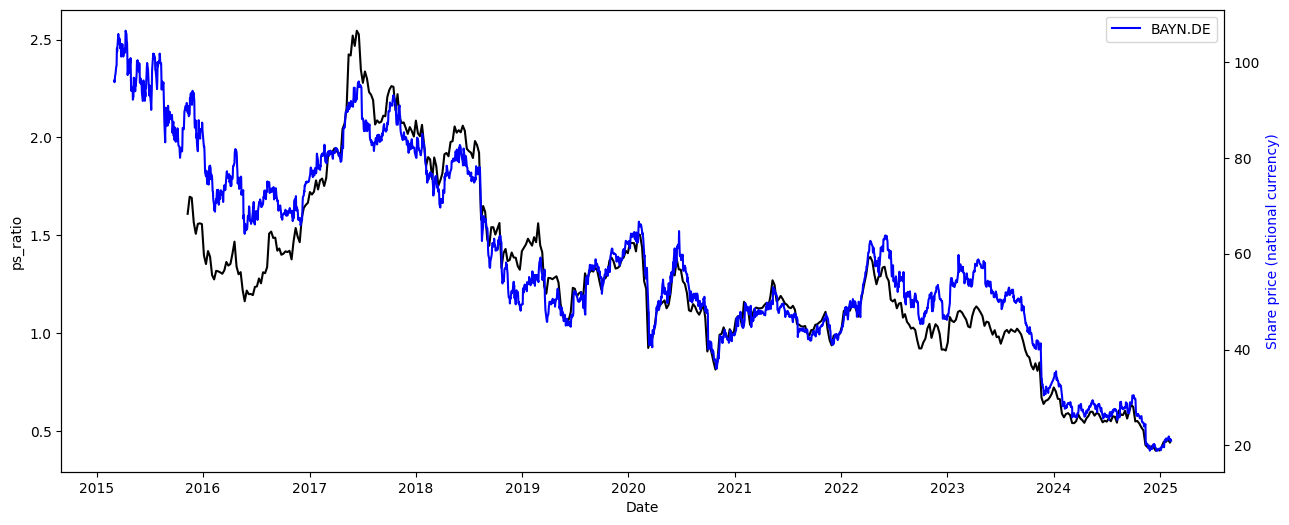

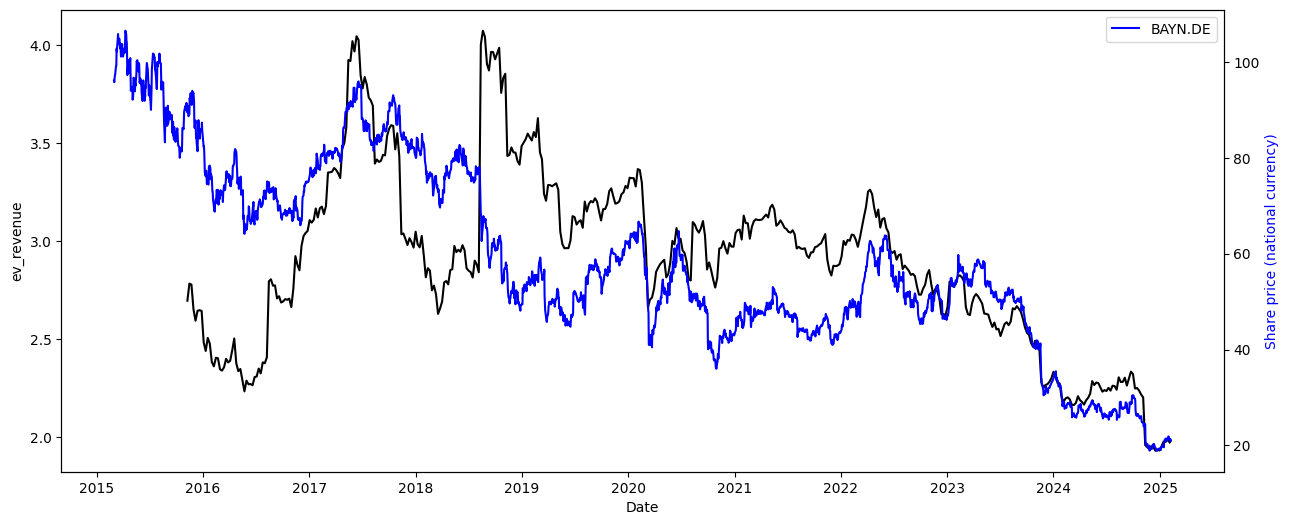

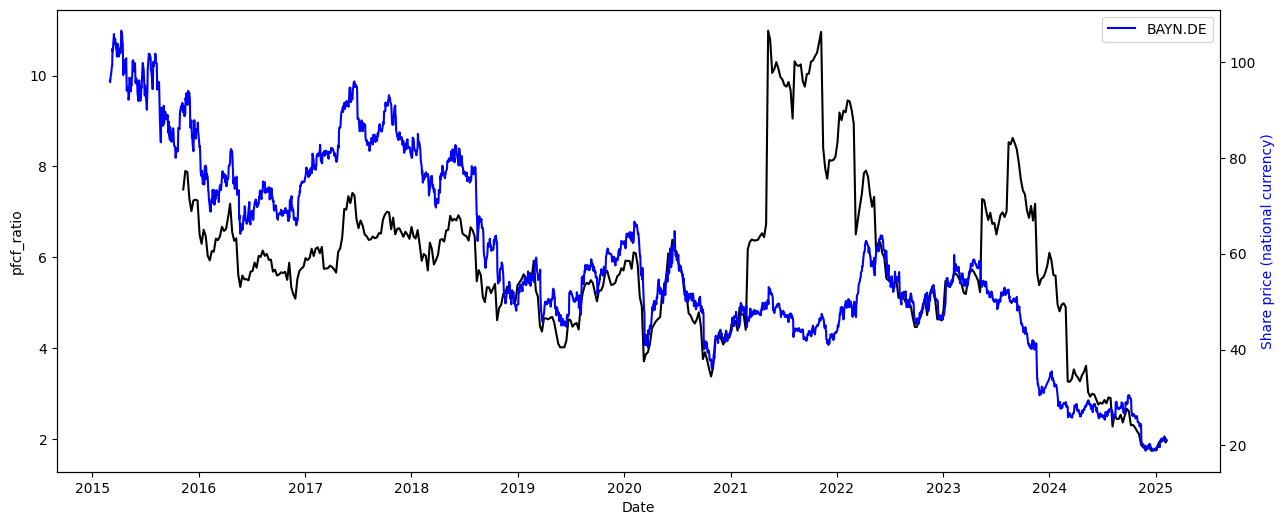

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

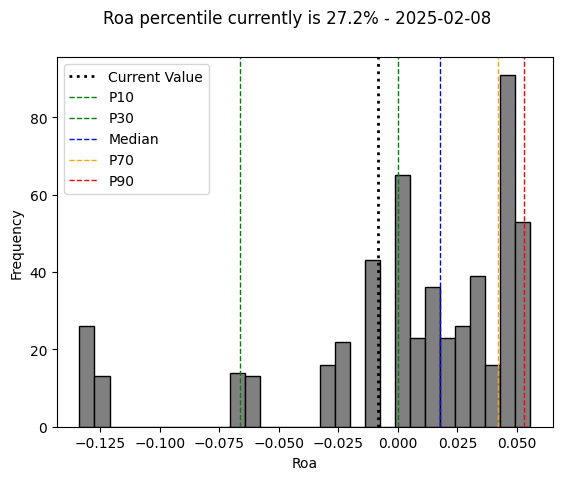

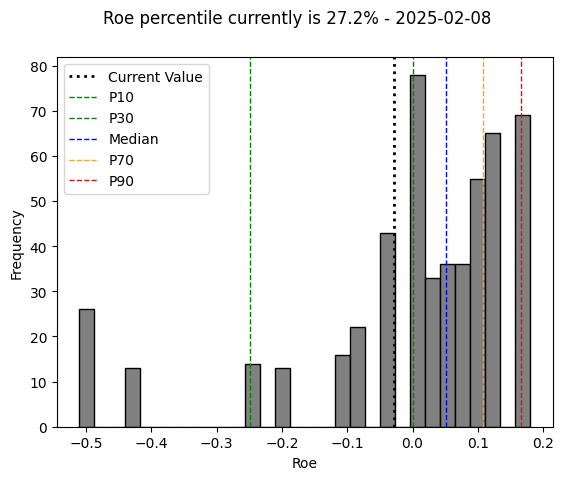

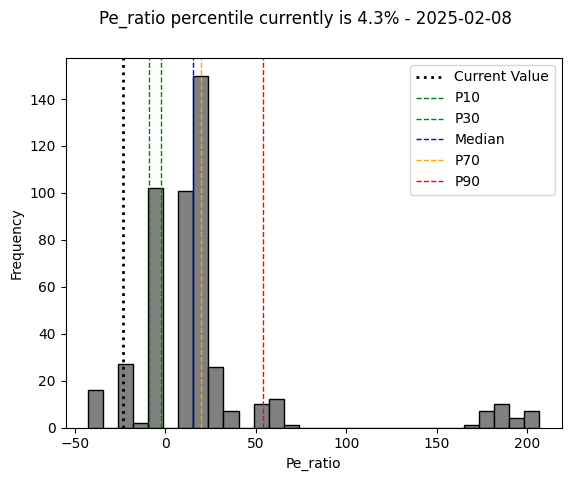

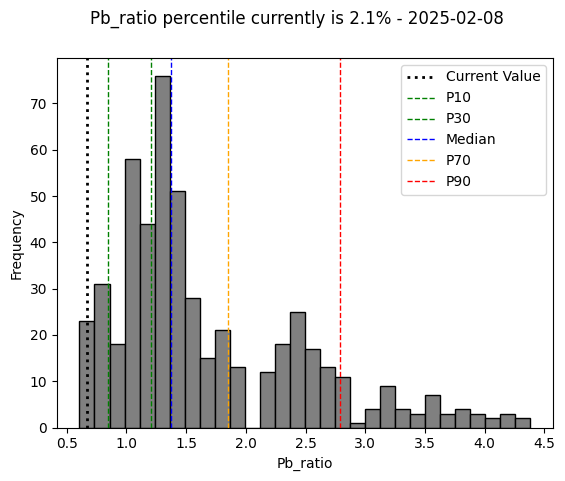

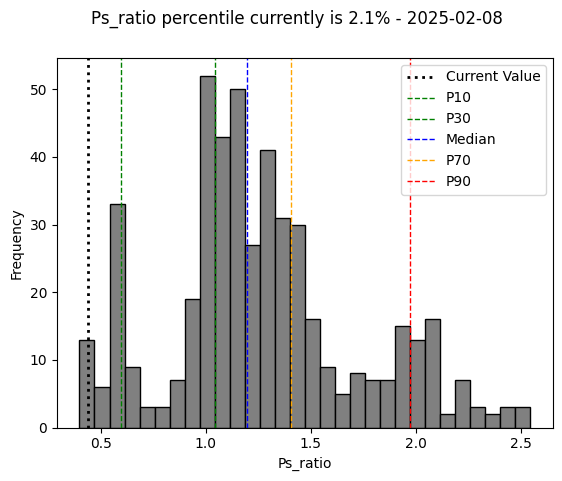

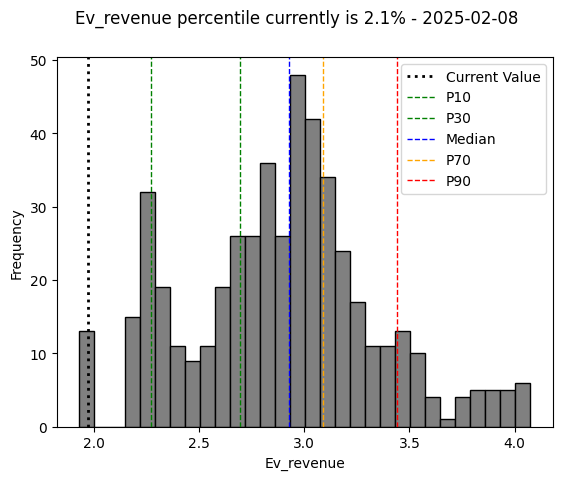

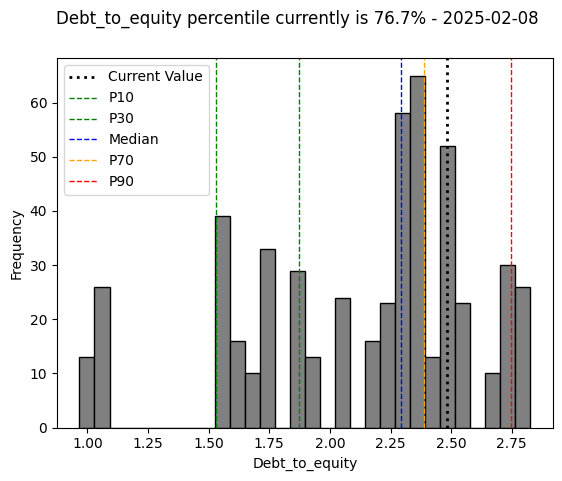

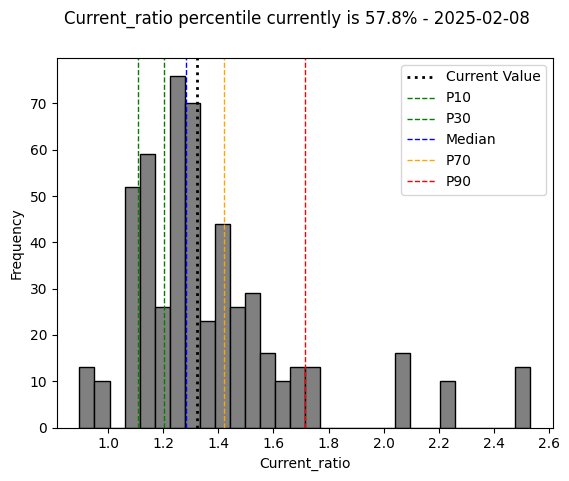

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.992629,0.168456,0.296002,0.466036,0.050190,-0.571729,0.518403
roe,0.992629,1.000000,0.180605,0.286956,0.391142,0.011904,-0.502145,0.434495
pe_ratio,0.168456,0.180605,1.000000,0.064153,0.117201,0.199294,-0.010690,-0.032560
pb_ratio,0.296002,0.286956,0.064153,1.000000,0.687435,0.197656,0.022073,0.214777
ps_ratio,0.466036,0.391142,0.117201,0.687435,1.000000,0.686416,-0.684836,0.696260
ev_revenue,0.050190,0.011904,0.199294,0.197656,0.686416,1.000000,-0.354736,0.187633
debt_to_equity,-0.571729,-0.502145,-0.010690,0.022073,-0.684836,-0.354736,1.000000,-0.836416
current_ratio,0.518403,0.434495,-0.032560,0.214777,0.696260,0.187633,-0.836416,1.000000


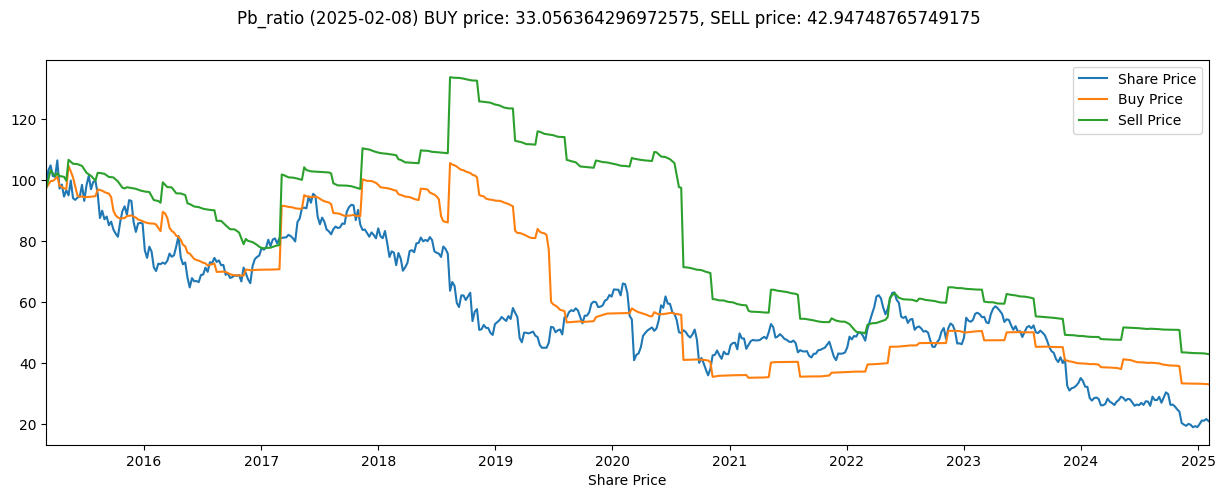

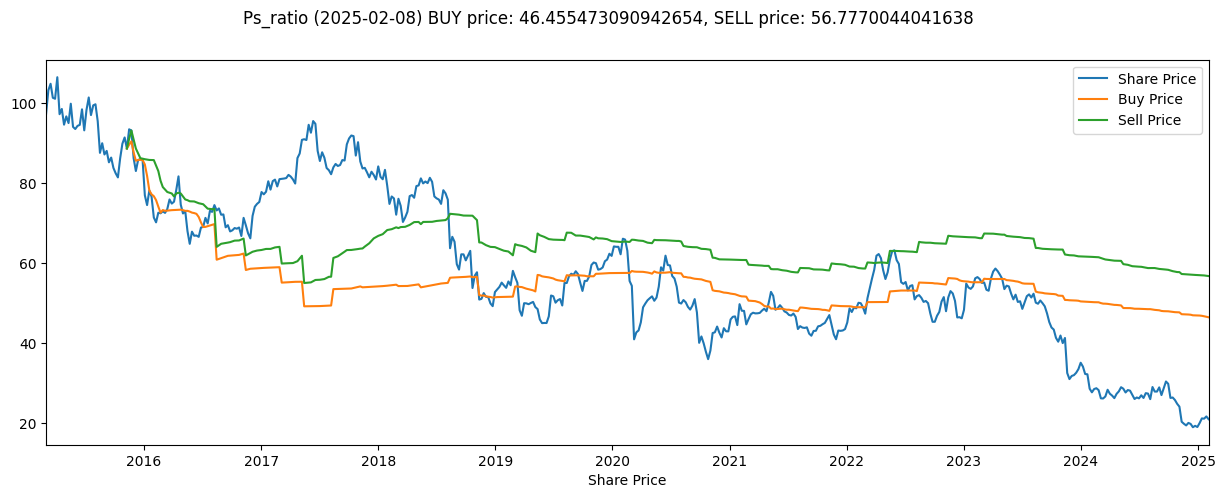

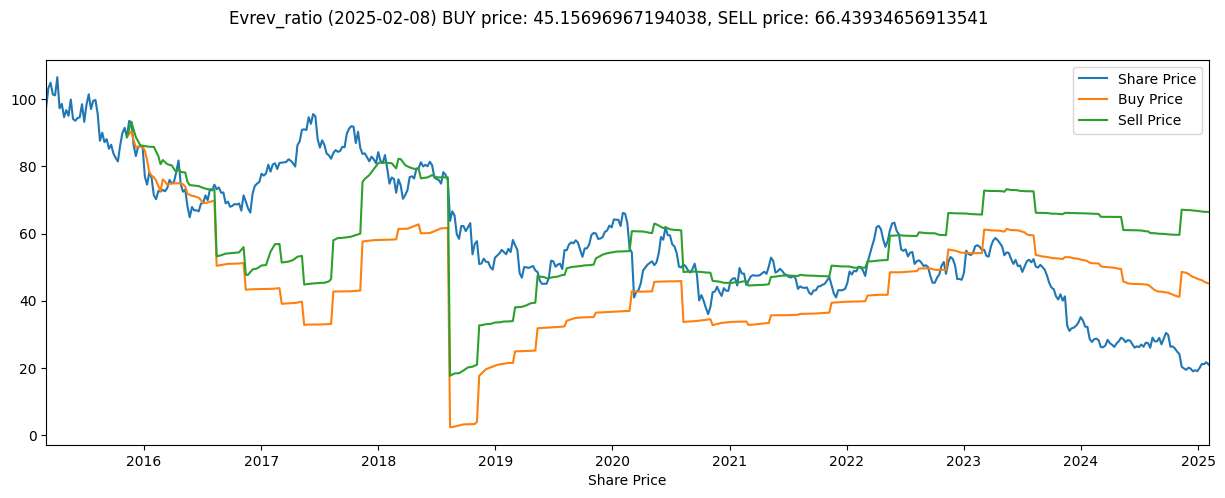

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)